<a href="https://colab.research.google.com/github/Swap1984/Dynamic-Fuel-Price-Optimization/blob/main/Dynamic_Fuel_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Business Context:

A retail petrol company operates in an open market where competitors freely change their daily prices. The company can set its own retail price once per day, at the start of the day. The objective is to maximize daily profit by choosing the right price, using historical data and a daily feed of market inputs.

Objective:

To develop an ML system that:

•   	Recommends the optimum daily retail price to maximize total profit.

•   	Handles data ingestion, transformation, and feature computation efficiently.

•   	Can be easily extended and deployed in a real-world scenario.





# Data Observation and Data Cleaning

For current pricing problem, we should primarily analyze demand stability, time-based effects, and competitive price positioning.We should specifically look for relative price elasticity rather than absolute price sensitivity, since customer choice is generally influenced by nearby alternatives. Cost should be treated as a margin input and not as a demand driver

In [6]:
# Importing essential Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For better visuals
plt.style.use("seaborn-v0_8")


In [7]:
# Reading the data
df = pd.read_csv("oil_retail_history.csv")
df.head()


,date,price,cost,comp1_price,comp2_price,comp3_price,volume
0,2023-01-01,97.66,86.46,98.39,99.10,97.37,13513
1,2023-01-02,96.46,87.25,95.37,96.25,97.38,13605
2,2023-01-03,94.67,86.40,94.41,94.69,94.50,16540
3,2023-01-04,97.32,87.51,99.12,96.90,97.54,14927
4,2023-01-05,94.08,86.38,93.31,94.61,93.85,13332


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         730 non-null    object 
 1   price        730 non-null    float64
 2   cost         730 non-null    float64
 3   comp1_price  730 non-null    float64
 4   comp2_price  730 non-null    float64
 5   comp3_price  730 non-null    float64
 6   volume       730 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 40.1+ KB


In [9]:
df.describe()

,price,cost,comp1_price,comp2_price,comp3_price,volume
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,96.505301,86.498178,96.551658,96.530068,96.457260,13960.983562
std,2.747598,1.575689,2.779654,2.796763,2.782295,905.912360
min,88.080000,83.340000,88.320000,87.070000,86.080000,11397.000000
25%,94.670000,85.302500,94.555000,94.827500,94.712500,13326.250000
50%,96.525000,86.255000,96.590000,96.430000,96.515000,13882.000000
75%,98.420000,87.610000,98.467500,98.447500,98.097500,14538.750000
max,104.890000,91.860000,104.200000,105.000000,104.360000,16890.000000


In [10]:
# Date Parsing & Time-Based Features (For seasonality analysis)
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df

,date,price,cost,comp1_price,comp2_price,comp3_price,volume,day_of_week,month
0,2023-01-01,97.66,86.46,98.39,99.10,97.37,13513,6,1
1,2023-01-02,96.46,87.25,95.37,96.25,97.38,13605,0,1
2,2023-01-03,94.67,86.40,94.41,94.69,94.50,16540,1,1
3,2023-01-04,97.32,87.51,99.12,96.90,97.54,14927,2,1
4,2023-01-05,94.08,86.38,93.31,94.61,93.85,13332,3,1
...,...,...,...,...,...,...,...,...,...
725,2024-12-26,91.53,85.35,91.61,90.11,91.92,14393,3,12
726,2024-12-27,97.36,83.68,98.59,95.63,97.39,13306,4,12
727,2024-12-28,91.01,85.44,92.42,92.85,90.22,12169,5,12
728,2024-12-29,95.74,85.26,95.39,94.94,96.77,14296,6,12


We have extracted time-based features to separate natural demand variation from price-induced variation, ensuring the pricing model learns true price sensitivity rather than calendar effects.

In [11]:
# Competitor Price ContextCompetitor Price Context (Critical Step)
# Customers would compare our price vs Competitors so lets have a avgerage competitor Price column added to our data
df['avg_comp_price'] = df[['comp1_price', 'comp2_price', 'comp3_price']].mean(axis=1)
df['price_diff'] = df['price'] - df['avg_comp_price']# price_diff is the most important elasticity signal
df

,date,price,cost,comp1_price,comp2_price,comp3_price,volume,day_of_week,month,avg_comp_price,price_diff
0,2023-01-01,97.66,86.46,98.39,99.10,97.37,13513,6,1,98.286667,-0.626667
1,2023-01-02,96.46,87.25,95.37,96.25,97.38,13605,0,1,96.333333,0.126667
2,2023-01-03,94.67,86.40,94.41,94.69,94.50,16540,1,1,94.533333,0.136667
3,2023-01-04,97.32,87.51,99.12,96.90,97.54,14927,2,1,97.853333,-0.533333
4,2023-01-05,94.08,86.38,93.31,94.61,93.85,13332,3,1,93.923333,0.156667
...,...,...,...,...,...,...,...,...,...,...,...
725,2024-12-26,91.53,85.35,91.61,90.11,91.92,14393,3,12,91.213333,0.316667
726,2024-12-27,97.36,83.68,98.59,95.63,97.39,13306,4,12,97.203333,0.156667
727,2024-12-28,91.01,85.44,92.42,92.85,90.22,12169,5,12,91.830000,-0.820000
728,2024-12-29,95.74,85.26,95.39,94.94,96.77,14296,6,12,95.700000,0.040000


# Visualizing the Volume(Fuel demand ~ sales in our case), effect of Seasonality and Competitior pricing on demad for fuel


In this dataset, volume represents actual sales, and we treat it as real fuel demand.

In [12]:
df['volume'].describe()

,volume
count,730.000000
mean,13960.983562
std,905.912360
min,11397.000000
25%,13326.250000
50%,13882.000000
75%,14538.750000
max,16890.000000


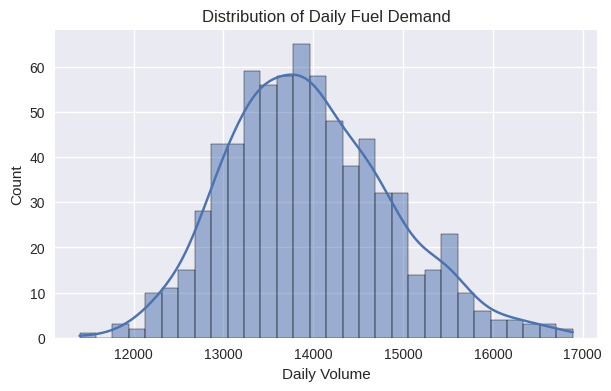

In [13]:
plt.figure(figsize=(7,4))
sns.histplot(df['volume'], bins=30, kde=True)
plt.title("Distribution of Daily Fuel Demand")
plt.xlabel("Daily Volume")
plt.show()

We have used a histogram with count on the y-axis to understand the distribution and stability of daily demand. It shows how frequently different demand levels occur, helping us assess volatility and whether pricing optimization is feasible
This hitogram indicates that the fuel demand mostly lies in a tight range and that it is stable and predictable


# Effects of Seasonality

Plotting weekly trend

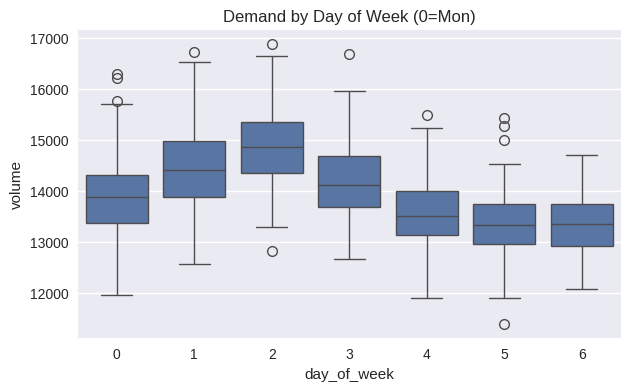

In [14]:
df['day_of_week'] = df['date'].dt.dayofweek
plt.figure(figsize=(7,4))
sns.boxplot(x='day_of_week', y='volume', data=df)
plt.title("Demand by Day of Week (0=Mon)")
plt.show()


We can see behavioral demand patterns,
We see that volume sold is different each day and so same price may yield diffeent profits depending on the day of week.

Plotting monthly trend

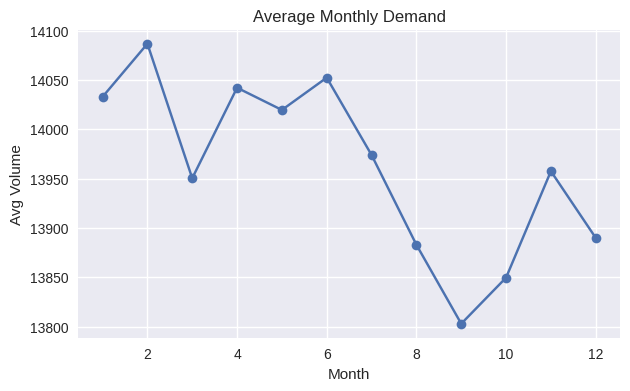

In [15]:
df['month'] = df['date'].dt.month
monthly_demand = df.groupby('month')['volume'].mean()

plt.figure(figsize=(7,4))
monthly_demand.plot(marker='o')
plt.title("Average Monthly Demand")
plt.xlabel("Month")
plt.ylabel("Avg Volume")
plt.show()


Here we see that the volume sold(avg volume per day) is not showing significant decreases as we proceed from Jan to Dec

Plotting Absolute Price vs Demand

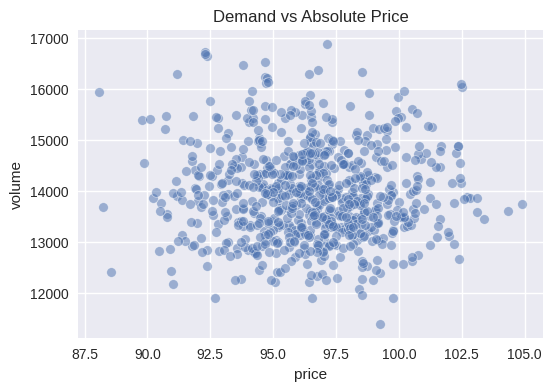

In [16]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='price', y='volume', data=df, alpha=0.5)
plt.title("Demand vs Absolute Price")
plt.show()


We see that Demand does not consistently decrease as absolute price increases.Points are widely scattered.This indicates low absolute price elasticity.Consumers compare relative prices across nearby stations.
Small absolute price changes have limited impact in isolation

In [17]:
df[['price','volume']].corr()


,price,volume
price,1.00000,-0.04066
volume,-0.04066,1.00000


# Effect of Competitor pricing

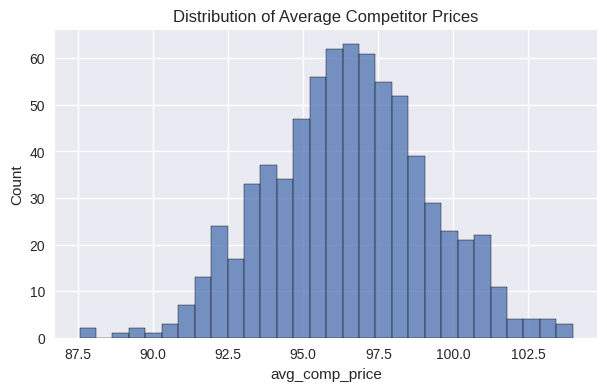

In [18]:
df['avg_comp_price'] = df[['comp1_price','comp2_price','comp3_price']].mean(axis=1)
plt.figure(figsize=(7,4))
sns.histplot(df['avg_comp_price'], bins=30)
plt.title("Distribution of Average Competitor Prices")
plt.show()


The count here refers to the no of days the particular price occured.So we understand how frequently the market operates at a give price.
Customers are highly sensitive to relative pricing.
Even small disadvantages reduce volume.

# Effect of price difference on fuel demand

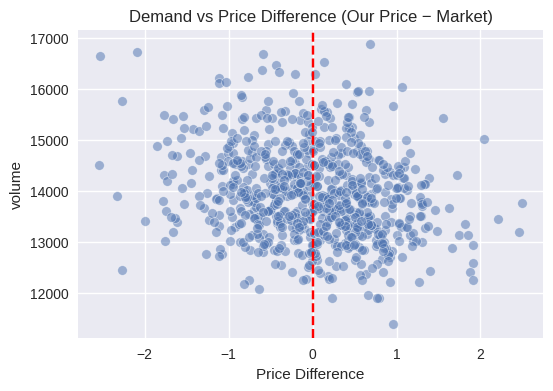

In [19]:
df['price_diff'] = df['price'] - df['avg_comp_price']

plt.figure(figsize=(6,4))
sns.scatterplot(x='price_diff', y='volume', data=df, alpha=0.5)
plt.axvline(0, color='red', linestyle='--')
plt.title("Demand vs Price Difference (Our Price − Market)")
plt.xlabel("Price Difference")
plt.show()


In [20]:
df[['price_diff','volume']].corr()


,price_diff,volume
price_diff,1.000000,-0.233312
volume,-0.233312,1.000000


from matplotlib import pyplot as plt
_df_0['price_diff'].plot(kind='hist', bins=20, title='price_diff')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['volume'].plot(kind='hist', bins=20, title='volume')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='price_diff', y='volume', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['volume']
  ys = series['price_diff']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('volume', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('volume')
_ = plt.ylabel('price_diff')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['volume']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'volume'}, axis=1)
              .sort_values('volume', ascending=True))
  xs = counted['volume']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('volume', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('volume')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['price_diff'].plot(kind='line', figsize=(8, 4), title='price_diff')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['volume'].plot(kind='line', figsize=(8, 4), title='volume')
plt.gca().spines[['top', 'right']].set_visible(False)

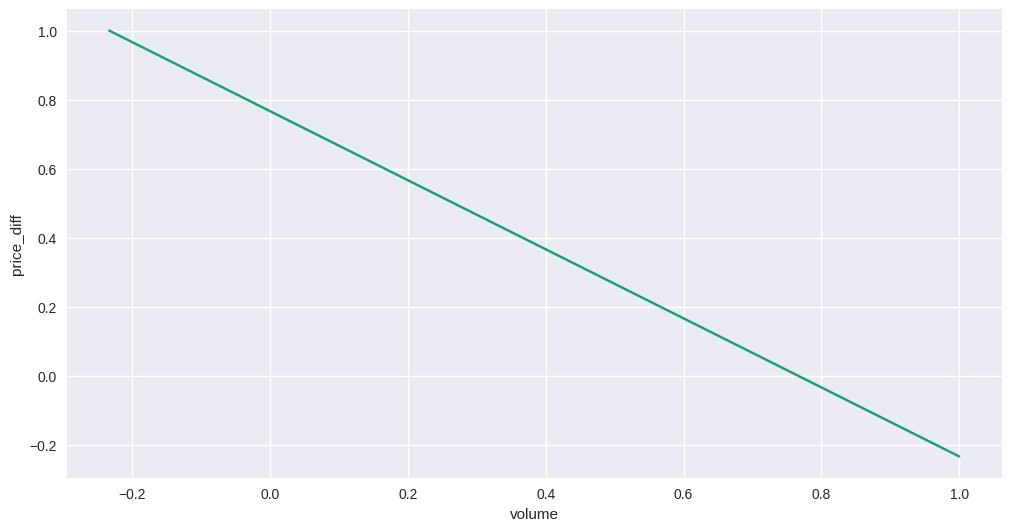

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['volume']
  ys = series['price_diff']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('volume', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('volume')
_ = plt.ylabel('price_diff')

We see that Demand drops when price_diff > 0.This indicates significant effect of competitor price on fuel demad(sales for us in the present case)

# Effect of  our cost on fuel demand

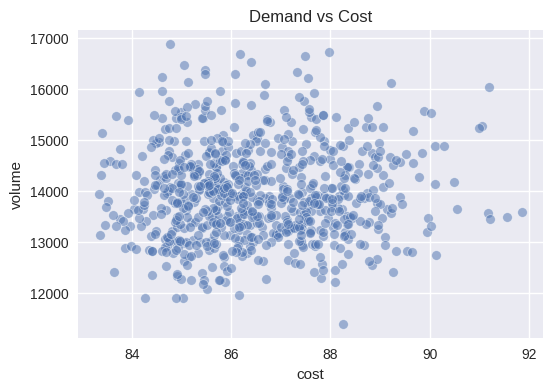

In [26]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='cost', y='volume', data=df, alpha=0.5)
plt.title("Demand vs Cost")
plt.show()



In [27]:
df[['cost','volume']].corr()


,cost,volume
cost,1.00000,0.03259
volume,0.03259,1.00000


from matplotlib import pyplot as plt
_df_7['cost'].plot(kind='hist', bins=20, title='cost')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['volume'].plot(kind='hist', bins=20, title='volume')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='cost', y='volume', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['volume']
  ys = series['cost']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('volume', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('volume')
_ = plt.ylabel('cost')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['volume']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'volume'}, axis=1)
              .sort_values('volume', ascending=True))
  xs = counted['volume']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('volume', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('volume')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['cost'].plot(kind='line', figsize=(8, 4), title='cost')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['volume'].plot(kind='line', figsize=(8, 4), title='volume')
plt.gca().spines[['top', 'right']].set_visible(False)

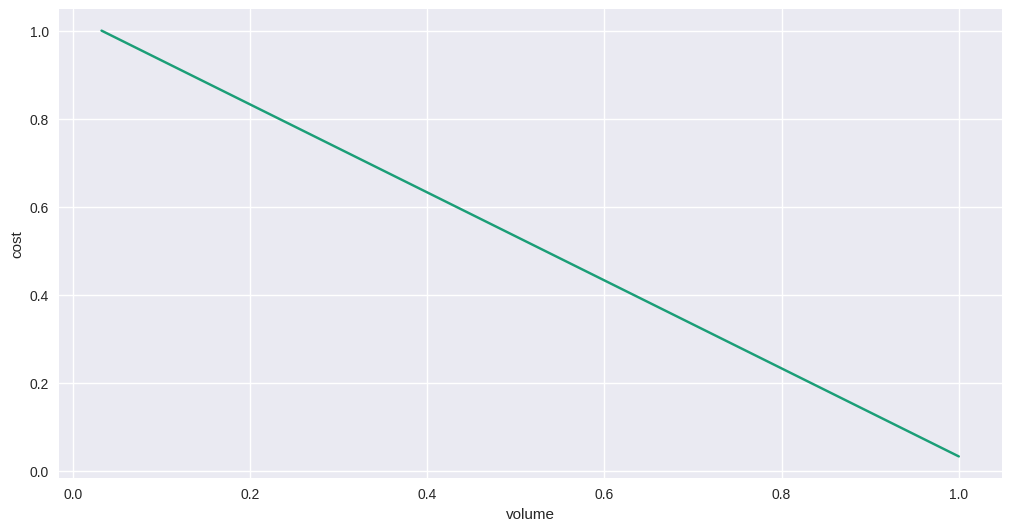

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['volume']
  ys = series['cost']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('volume', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('volume')
_ = plt.ylabel('cost')

We see that cost affects profit and not fuel demand or customers behaviour.

# Studying Market Volatility

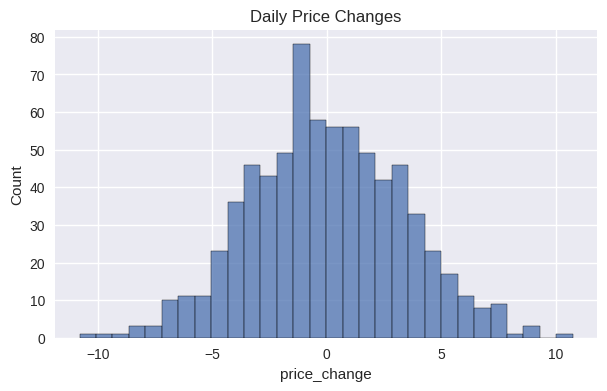

In [31]:
df.sort_values('date', inplace=True)
df['price_change'] = df['price'].diff()

plt.figure(figsize=(7,4))
sns.histplot(df['price_change'].dropna(), bins=30)
plt.title("Daily Price Changes")
plt.show()


The plot explains how much the price change from one day to the next. here the count referes to the no of days that price chane was observed.
We also see that the mostly the price do not change. There are very rare cases of large price change.

Thus the Price volatility analysis shows that the market operates with gradual price changes, allowing daily optimization with guardrails rather than aggressive repricing

# Lets check whether the demand response is linear and symmetric.

In [32]:
df['price_bucket'] = pd.cut(
    df['price_diff'],
    bins=[-np.inf, -1, 0, 1, np.inf],
    labels=['Very Cheap','Slightly Cheap','Slightly Expensive','Very Expensive']
)

df.groupby('price_bucket')['volume'].mean()


/tmp/ipython-input-2852953872.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('price_bucket')['volume'].mean()


,volume
price_bucket,
Very Cheap,14394.575342
Slightly Cheap,14046.817544
Slightly Expensive,13839.460526
Very Expensive,13679.044118


Thus we see that the demand falls faster when overpriced than it rises when underpriced.

So we can conclude that the dominant driver of demand is relative price positioning versus competitors. Day-of-week provides operational context, while absolute price alone has weak explanatory power. Cost does not influence demand directly and is used only for profit optimization.

# Choice of predictive models

As the demand response to pricing is asymmetric and non-linear, with sharper drops when overpriced. This requires non-linear predictive demand models

# Developing model for the current price prdiction

In [33]:
#Importing necessary libraries
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
#Loading and preparing data
df = pd.read_csv("oil_retail_history.csv")
df['date'] = pd.to_datetime(df['date'])

# Time features
df['day_of_week'] = df['date'].dt.dayofweek

# Competitive context
df['avg_comp_price'] = df[['comp1_price','comp2_price','comp3_price']].mean(axis=1)
df['price_diff'] = df['price'] - df['avg_comp_price']


In [35]:
# Setting predictive features and target
FEATURES = [
    'price',
    'price_diff',
    'avg_comp_price',
    'cost',
    'day_of_week'
]

TARGET = 'volume'

X = df[FEATURES]
y = df[TARGET]


In [36]:
# Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [37]:
# loading the model
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [38]:
# Evaluating the model
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 :", r2_score(y_test, y_pred))


MAE: 594.0134887695312
R2 : 0.25989341735839844


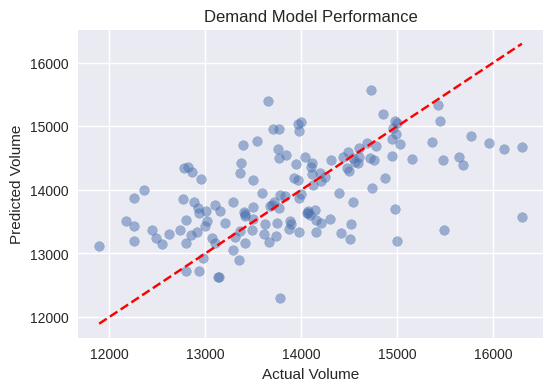

In [39]:
# Visualising Actual vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Volume")
plt.ylabel("Predicted Volume")
plt.title("Demand Model Performance")
plt.show()


In [40]:
# setting business guardrails
def apply_business_rules(
    candidate_prices,
    current_price,
    cost,
    avg_comp_price,
    max_daily_change=2.0,
    min_margin=1.0,
    max_competitive_gap=3.0
):
    prices = []

    for p in candidate_prices:
        # Rule 1: Max daily price change
        if abs(p - current_price) > max_daily_change:
            continue

        # Rule 2: Minimum margin
        if p < cost + min_margin:
            continue

        # Rule 3: Competitive alignment
        if abs(p - avg_comp_price) > max_competitive_gap:
            continue

        prices.append(p)

    return prices


In [41]:
# Price optimization
def optimize_price(today_row, model):
    cost = today_row['cost']
    current_price = today_row['price']
    avg_comp_price = today_row['avg_comp_price']

    # Candidate prices
    candidate_prices = np.arange(cost + 1, cost + 15, 0.1)

    # Apply business constraints
    candidate_prices = apply_business_rules(
        candidate_prices,
        current_price,
        cost,
        avg_comp_price
    )

    results = []

    for p in candidate_prices:
        features = today_row.copy()
        features['price'] = p
        features['price_diff'] = p - avg_comp_price

        X = features[FEATURES].values.reshape(1, -1)
        predicted_volume = model.predict(X)[0]

        profit = (p - cost) * predicted_volume

        results.append((p, predicted_volume, profit))

    results_df = pd.DataFrame(
        results,
        columns=['price','expected_volume','expected_profit']
    )

    return results_df.sort_values('expected_profit', ascending=False)


In [42]:
# Historical Backtest
def backtest(df, model, n_days=60):
    profits_actual = []
    profits_model = []

    for i in range(-n_days, -1):
        row = df.iloc[i]
        today = row.copy()

        today['avg_comp_price'] = row[['comp1_price','comp2_price','comp3_price']].mean()
        today['price_diff'] = row['price'] - today['avg_comp_price']

        optimized = optimize_price(today, model)

        best = optimized.iloc[0]

        profits_model.append(best['expected_profit'])
        profits_actual.append((row['price'] - row['cost']) * row['volume'])

    return profits_actual, profits_model


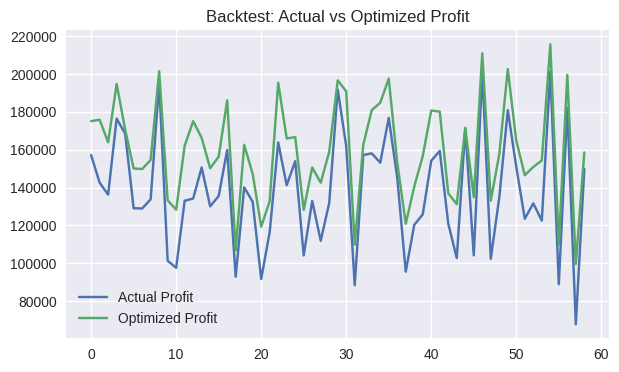

In [43]:
# Plotting Actual vs OPtimized profit
actual, model_profit = backtest(df, model)

plt.figure(figsize=(7,4))
plt.plot(actual, label="Actual Profit")
plt.plot(model_profit, label="Optimized Profit")
plt.legend()
plt.title("Backtest: Actual vs Optimized Profit")
plt.show()


# Reusable System design

In [44]:
import json
import numpy as np
import pandas as pd

def pricing_system(today_json_path, model):
    # ---- Load JSON SAFELY ----
    with open(today_json_path, "r") as f:
        today_dict = json.load(f)

    today = pd.DataFrame([today_dict])  # ✅ FIX

    # ---- Feature Engineering ----
    today['date'] = pd.to_datetime(today['date'])
    today['day_of_week'] = today['date'].dt.dayofweek
    today['avg_comp_price'] = today[['comp1_price','comp2_price','comp3_price']].mean(axis=1)
    today['price_diff'] = today['price'] - today['avg_comp_price']

    # ---- Scalars ----
    cost = today.loc[0, 'cost']
    current_price = today.loc[0, 'price']
    avg_comp_price = today.loc[0, 'avg_comp_price']

    # ---- Candidate Prices ----
    candidate_prices = np.arange(cost + 1, cost + 15, 0.1)

    candidate_prices = apply_business_rules(
        candidate_prices=candidate_prices,
        current_price=current_price,
        cost=cost,
        avg_comp_price=avg_comp_price
    )

    results = []

    for p in candidate_prices:
        row = today.copy()
        row['price'] = p
        row['price_diff'] = p - avg_comp_price

        X = row[FEATURES].values
        predicted_volume = model.predict(X)[0]

        profit = (p - cost) * predicted_volume
        results.append((p, predicted_volume, profit))

    results_df = pd.DataFrame(
        results,
        columns=['price','expected_volume','expected_profit']
    )

    best = results_df.sort_values('expected_profit', ascending=False).iloc[0]

    return {
        "recommended_price": round(best['price'], 2),
        "expected_volume": int(round(best['expected_volume'], 0)),
        "expected_profit": round(best['expected_profit'], 2)
    }


In [45]:
pricing_system("today_example.json", model)


{'recommended_price': np.float64(96.37),
 'expected_volume': 14026,
 'expected_profit': np.float64(148673.01)}